Autor: ÁLLIFE LICIO LACERDA

Breve estudo realizado durante a elaboração do meu Trabalho de Conclusão de Curso.

**Este material é puramente educacional.**

**Este material NÃO é uma indicação de investimento.**

In [214]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas_datareader as web
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import math

Podemos obter os dados de ações diretamente da internet utilizando a biblioteca *pandas_datareader*

Vamos utilizar como exemplo dois anos de ações de Petrobrás.

In [215]:
df_petr4 = web.DataReader('PETR4.SA', data_source='yahoo', start='2020-02-10', end='2022-02-10')

In [216]:
df_petr4.head(3)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-02-10,29.129999,28.639999,28.889999,29.129999,45328100.0,23.674875
2020-02-11,29.629999,29.260000,29.400000,29.480000,37518200.0,23.959332
2020-02-12,30.280001,29.629999,29.639999,30.129999,64851000.0,24.487608


In [217]:
df_petr4.shape

(497, 6)

Visualizando o comportamento do *preço de fechamento* de PETR4 nos últimos 2 anos.

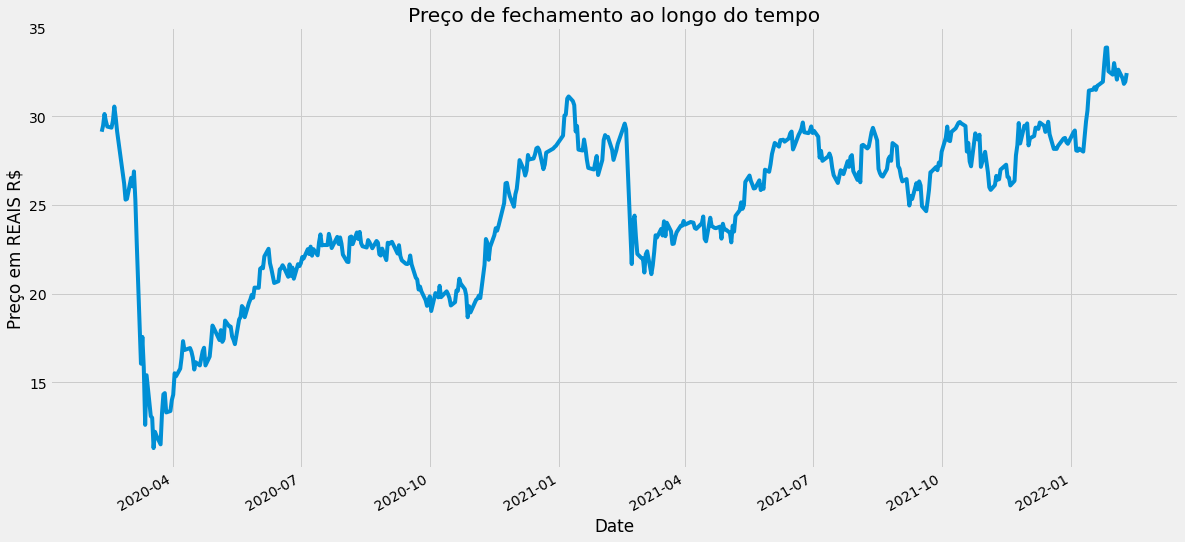

In [218]:
df_petr4['Close'].plot(figsize=(18,9))
plt.title("Preço de fechamento ao longo do tempo")
plt.ylabel("Preço em REAIS R$")
plt.show()

Isolando a coluna **Close** do conjunto de dados.

In [219]:
data = df_petr4.filter(['Close'])

In [220]:
dataset = data.values

In [221]:
print(type(dataset))
print(len(dataset))

<class 'numpy.ndarray'>
497


Muitos algoritmos de aprendizado de máquina funcionam melhor quando as variáveis de entrada numérica são dimensionadas para um intervalo padrão.

Vamos aplicar a normalização nos preços de fechamento das ações.

In [222]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

In [223]:
scaled_data[:10]

array([[0.78972989],
       [0.80522349],
       [0.83399727],
       [0.81584765],
       [0.80256747],
       [0.79991145],
       [0.8171757 ],
       [0.85258957],
       [0.82470116],
       [0.79017258]])

Vou utilizar 80% para treino e 20% para teste.
<br>
Neste estudo foram separados os dados de treino e teste manualmente.

In [224]:
training_data_len = math.ceil(len(scaled_data) * 0.8)
training_data_len

398

In [225]:
train_data = scaled_data[0:training_data_len, :]

Criando os arrays de treino.<br>
1º ao 30º -> 1 valor<br>
2º ao 31º -> 1 valor<br>
...<br>
x_train é um array de arrays<br>
y_train é um array de float

In [226]:
x_train = []
y_train = []
for i in range(30, training_data_len):
    x_train.append(train_data[i-30:i, 0])
    y_train.append(train_data[i,0])

Visualizando...

In [227]:
print(x_train[0])
print("\n")
print(y_train[0])

[0.78972989 0.80522349 0.83399727 0.81584765 0.80256747 0.79991145
 0.8171757  0.85258957 0.82470116 0.79017258 0.66046916 0.62018586
 0.6219566  0.67463479 0.65338639 0.69057099 0.61974326 0.51084548
 0.21071266 0.27755641 0.20185924 0.05799028 0.18193889 0.07968128
 0.07569721 0.         0.04072599 0.03142984 0.00929615 0.08676405]


0.13413012769314303


30 valores vão gerar 1 valor, e assim sucessivamente.

In [228]:
x_train = np.array(x_train)
y_train = np.array(y_train)

In [229]:
x_train.shape

(368, 30)

In [230]:
 x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [231]:
x_train.shape

(368, 30, 1)

**LSTM**<br>
Redes de Memória de Curto Prazo Longo — geralmente chamadas apenas de “LSTMs” — são um tipo especial de RNN, capaz de aprender dependências de longo prazo.
Os LSTMs são explicitamente projetados para evitar o problema de dependência de longo prazo.<br>

Fonte: https://www.deeplearningbook.com.br/arquitetura-de-redes-neurais-long-short-term-memory/

Construindo nosso modelo LSTM

In [232]:
model = Sequential()

In [233]:
model.add(LSTM(50,
               return_sequences = True,
               input_shape = (x_train.shape[1], 1)
              )
         )

model.add(LSTM(50,
               return_sequences = False
              )
         )
model.add(Dense(25))
model.add(Dense(1))

In [234]:
#https://faroit.com/keras-docs/1.1.0/optimizers/
#https://faroit.com/keras-docs/1.1.0/objectives/
model.compile(optimizer='adam', loss='mean_squared_error')

Treinando o modelo

In [235]:
model.fit(x_train, y_train, batch_size=1, epochs=1)

368/368 [==============================] - 4s 6ms/step - loss: 0.0069


Criando os arrays de teste...

In [236]:
test_data = scaled_data[training_data_len - 30: , :]
x_test = []
y_test = dataset[training_data_len: , :]
for i in range(30, len(test_data)):
    x_test.append(test_data[i-30:i, 0])

In [237]:
x_test = np.array(x_test)

In [238]:
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [239]:
x_test.shape

(99, 30, 1)

In [240]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

Avaliando nosso modelo utilizando RMSE.
<br>
RMSE (root mean squared error): é a medida que calcula "a raiz quadrática média" dos erros entre valores observados (reais) e predições (hipóteses).
<br>
Ou seja, é o desvio padrão da amostra da diferença entre o previsto e o teste

In [241]:
rmse=np.sqrt(np.mean(((predictions- y_test)**2)))

In [242]:
rmse

1.185667359142943

Visualizando nossos resultados...

<ipython-input-243-555fd4d2506b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict['Predictions'] = predictions


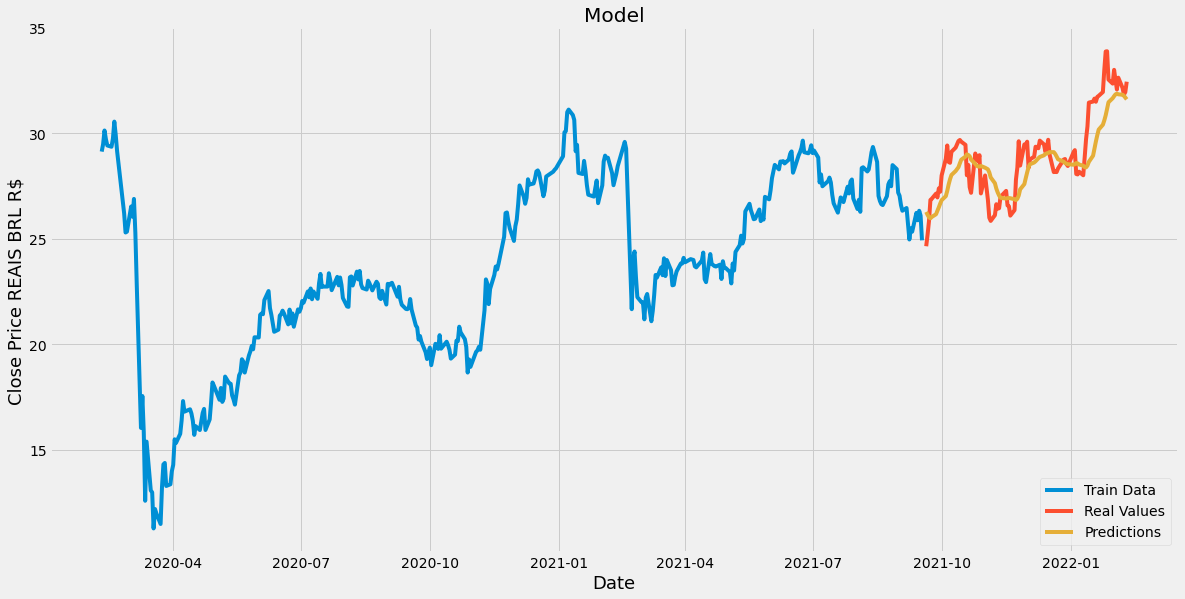

In [243]:
train = data[:training_data_len]
predict = data[training_data_len:]
predict['Predictions'] = predictions
plt.figure(figsize=(18,9))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price REAIS BRL R$', fontsize=18)
plt.plot(train['Close'])
plt.plot(predict[['Close','Predictions']])
plt.legend(['Train Data','Real Values','Predictions'], loc='lower right')
plt.show()

Comparando com o gráfico original...

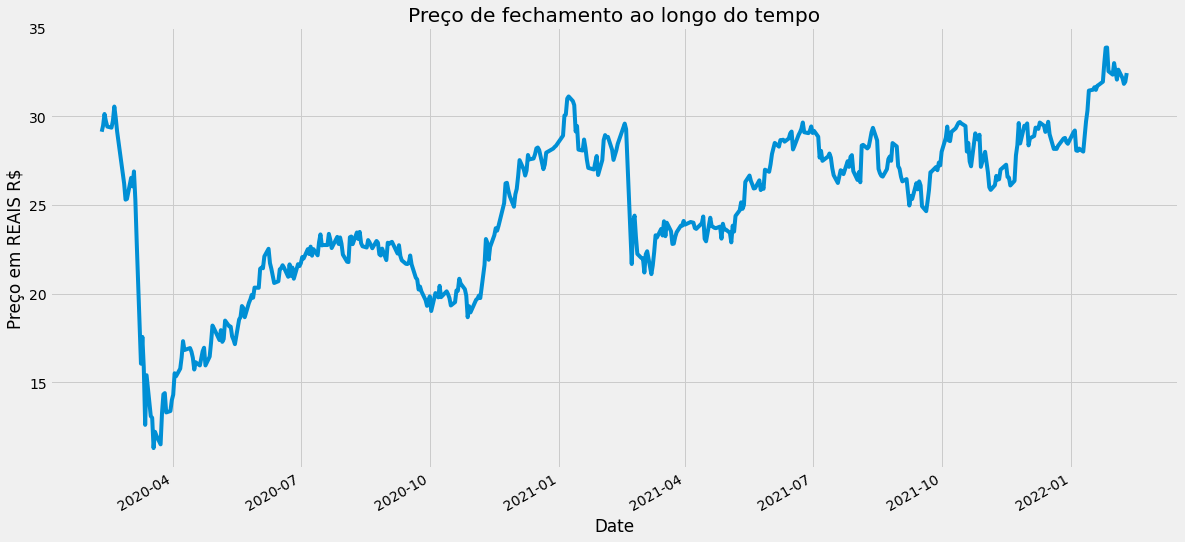

In [244]:
df_petr4['Close'].plot(figsize=(18,9))
plt.title("Preço de fechamento ao longo do tempo")
plt.ylabel("Preço em REAIS R$")
plt.show()

Comparando os valores reais e as previsões do modelo:

In [246]:
predict

,Close,Predictions
Date,,
2021-09-20,24.650000,26.274839
2021-09-21,25.209999,26.135458
2021-09-22,25.850000,26.020212
2021-09-23,26.840000,25.972940
2021-09-24,26.900000,26.038424
...,...,...
2022-02-04,32.630001,31.842796
2022-02-07,32.150002,31.822683
2022-02-08,31.830000,31.772680
